# Read in data from database

In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import HDBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

from utils.db_engine import DBEngine
db = DBEngine()
engine = db.get_engine()

import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

2025-04-12 01:32:09,040 - INFO - Database engine created successfully.


In [2]:
source = pd.read_sql("SELECT * FROM rental_listings", engine)
cols = ["listing_db_id", "latitude", "longitude"]
df = source[cols]

In [3]:
df.head()

,listing_db_id,latitude,longitude
0,1,38.929782,-76.990611
1,2,38.957134,-77.027605
2,3,38.873441,-77.015450
3,4,38.907160,-77.082872
4,5,38.929726,-76.990505


In [4]:
# Define parameter ranges to explore:
min_cluster_size_options = [5, 10, 15, 20]
min_samples_options = [None, 5, 10]

results = []

# Round close points to the same coordinates
df.loc[:, "latitude"] = df["latitude"].round(4)
df.loc[:, "longitude"] = df["longitude"].round(4)

# Convert to numpy
coordinates = df[["latitude", "longitude"]].to_numpy()

# Convert to radians
coordinates_radians = np.radians(coordinates)


for min_cluster_size in min_cluster_size_options:
    for min_samples in min_samples_options:
        # Create and fit the HDBSCAN clusterer
        hdbscan = HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            metric="haversine"
        )
        labels = hdbscan.fit_predict(coordinates_radians)
        
        # Count clusters and noise (ignoring label -1 which stands for noise)
        n_clusters = len(np.unique(labels)) - (1 if -1 in labels else 0)
        noise_points = np.sum(labels == -1)
        total_points = len(labels)
        fraction_noise = noise_points / total_points
        
        # Compute silhouette score only if more than 1 cluster and at least some valid points exist.
        if n_clusters > 1 and np.sum(labels != -1) > 0:
            try:
                sil_score = silhouette_score(coordinates_radians[labels != -1], labels[labels != -1], metric="haversine")
            except Exception as e:
                sil_score = np.nan
        else:
            sil_score = np.nan
        
        results.append({
            "min_cluster_size": min_cluster_size,
            "min_samples": min_samples,
            "n_clusters": n_clusters,
            "fraction_noise": fraction_noise,
            "silhouette": sil_score
        })

# Convert results to a DataFrame for easy analysis:
results_df = pd.DataFrame(results)
print(results_df)


    min_cluster_size  min_samples  n_clusters  fraction_noise  silhouette
0                  5          NaN        1516        0.168678    0.822439
1                  5          5.0        1516        0.168678    0.822439
2                  5         10.0         875        0.248482    0.825905
3                 10          NaN         784        0.239948    0.816516
4                 10          5.0         881        0.179980    0.760459
5                 10         10.0         784        0.239948    0.816516
6                 15          NaN         545        0.283962    0.798911
7                 15          5.0         635        0.193281    0.726552
8                 15         10.0         586        0.252979    0.778676
9                 20          NaN         406        0.319789    0.795607
10                20          5.0         498        0.211847    0.699536
11                20         10.0         450        0.264281    0.739706


In [5]:
# Choose the best parameters based on silhouette score and number of clusters
best_params = results_df.loc[results_df["silhouette"].idxmax()]
print(best_params)

min_cluster_size      5.000000
min_samples          10.000000
n_clusters          875.000000
fraction_noise        0.248482
silhouette            0.825905
Name: 2, dtype: float64


In [6]:
# Fit the HDBSCAN model with the best parameters
best_hdbscan = HDBSCAN(
    min_cluster_size=int(best_params["min_cluster_size"]),
    min_samples=int(best_params["min_samples"]),
    metric="haversine"
)

cluster_labels = best_hdbscan.fit_predict(coordinates_radians)

In [7]:
df.loc[:, "cluster"] = cluster_labels
# Check how many clusters were found (noise points are labeled -1)
num_clusters = len(np.unique(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f"Number of clusters found: {num_clusters}")

Number of clusters found: 875


/var/folders/66/1q8bft0j43j9_rs20_lp5zj80000gn/T/ipykernel_33620/2892069230.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "cluster"] = cluster_labels


In [8]:
df.head()

,listing_db_id,latitude,longitude,cluster
0,1,38.9298,-76.9906,-1
1,2,38.9571,-77.0276,-1
2,3,38.8734,-77.0154,-1
3,4,38.9072,-77.0829,-1
4,5,38.9297,-76.9905,-1


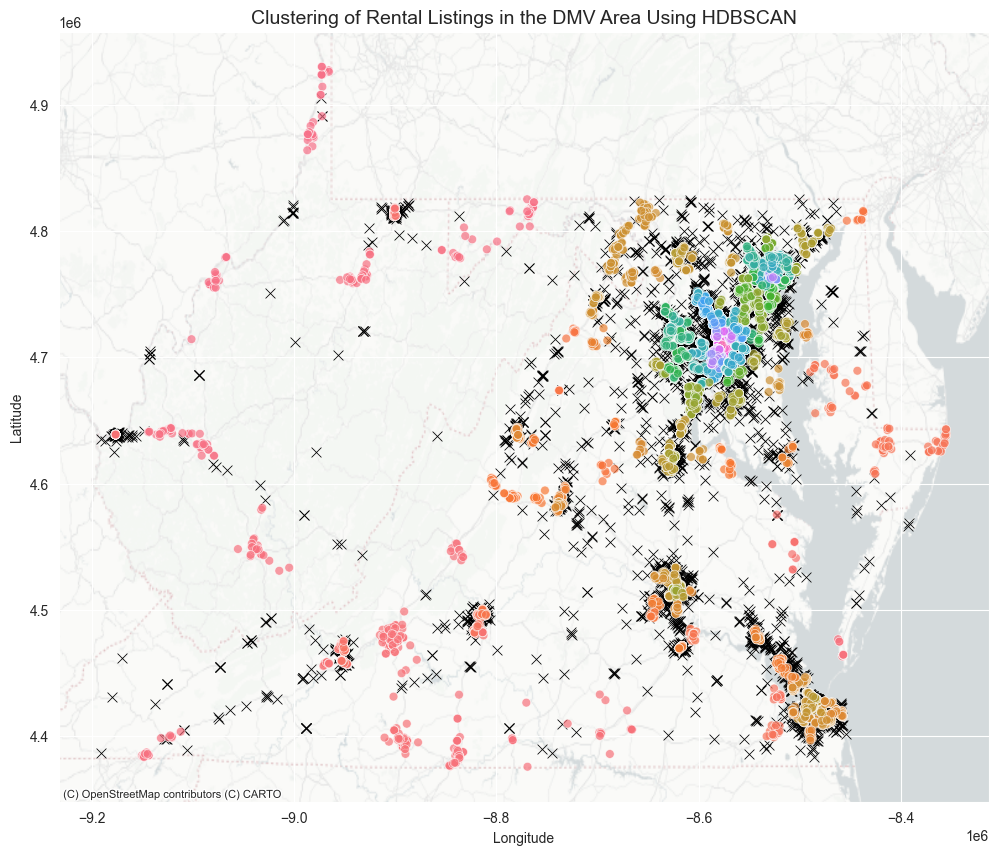

In [21]:
# Convert df to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"
)

# Project to Web Mercator for basemap compatibility
gdf = gdf.to_crs(epsg=3857)

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

unique_labels = np.unique(gdf["cluster"])
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)  # Exclude noise if present
palette = sns.color_palette("husl", n_colors=n_clusters)

# Create a new color column for plotting
gdf["point_color"] = gdf["cluster"].apply(lambda x: "black" if x == -1 else palette[x])

# Plot noise points separately if they exist
if -1 in unique_labels:
    noise_mask = gdf["cluster"] == -1
    sns.scatterplot(
        x=gdf.loc[noise_mask, "geometry"].x,
        y=gdf.loc[noise_mask, "geometry"].y,
        color="black",
        marker="x",
        s=50,
        label="Noise",
        ax=ax
    )

# Plot clusters (excluding noise)
cluster_mask = gdf["cluster"] != -1
sns.scatterplot(
    x=gdf.loc[cluster_mask, "geometry"].x,
    y=gdf.loc[cluster_mask, "geometry"].y,
    hue=gdf.loc[cluster_mask, "cluster"],
    palette=palette,
    marker="o",
    s=40,
    alpha=0.7,
    ax=ax,
    legend="brief"
)

# Set limits based on data bounds
xmin, ymin, xmax, ymax = gdf.total_bounds

# Add padding (5% on each side)
padding_x = (xmax - xmin) * 0.05
padding_y = (ymax - ymin) * 0.05

# Set expanded limits
ax.set_xlim(xmin - padding_x, xmax + padding_x)
ax.set_ylim(ymin - padding_y, ymax + padding_y)

# Add basemap
basemap_source = ctx.providers.CartoDB.PositronNoLabels

ctx.add_basemap(ax, source=basemap_source)

# Add titles and labels
ax.set_title("Clustering of Rental Listings in the DMV Area Using HDBSCAN", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.get_legend().remove()
ax.grid(True)
plt.show()

In [10]:
df_clusters = df[df["cluster"] != -1]
df_noise = df[df['cluster'] == -1].copy()

centroids = df_clusters.groupby("cluster")[["latitude", "longitude"]].mean().reset_index()
centroids.rename(columns={'latitude': 'centroid_lat', 'longitude': 'centroid_lon'}, inplace=True)

In [11]:
centroids.head()

,cluster,centroid_lat,centroid_lon
0,0,40.073043,-80.697057
1,1,40.386538,-80.589085
2,2,39.276865,-81.548352
3,3,39.647625,-78.774794
4,4,38.360848,-81.658820


In [12]:
df_noise.head()

,listing_db_id,latitude,longitude,cluster
0,1,38.9298,-76.9906,-1
1,2,38.9571,-77.0276,-1
2,3,38.8734,-77.0154,-1
3,4,38.9072,-77.0829,-1
4,5,38.9297,-76.9905,-1
